In [1]:
%reload_ext autoreload
%autoreload 2

In [31]:
import utils as u
import importlib
importlib.reload(u)
import io
import requests
import os
import pandas as pd
import numpy as np
from collections import Counter
from IPython.display import display, Markdown, Latex

In [3]:
r_orb = requests.post(
  'https://fink-portal.org/api/v1/ssocand',
  json={
    'kind': 'orbParams', # Mandatory, `orbParams` or `lightcurves`
  }
)
r_tra = requests.post(
  'https://fink-portal.org/api/v1/ssocand',
  json={
    'kind': 'lightcurves', # Mandatory, `orbParams` or `lightcurves`
  }
)

# Format output in a DataFrame
candid_reconstr_orbit = pd.read_json(io.BytesIO(r_orb.content))
candid_reconstr_traje = pd.read_json(io.BytesIO(r_tra.content))


## Results

In [4]:
Markdown("""|                     | Fink_FAT |                 |
|---------------------|----------|-----------------|
|                     | All      | Only with error |
| Reconstructed orbit | {:,}      | {:,}             |""".format(len(candid_reconstr_orbit), len(candid_reconstr_orbit[candid_reconstr_orbit["d:rms_a"] != -1.0])))

|                     | Fink_FAT |                 |
|---------------------|----------|-----------------|
|                     | All      | Only with error |
| Reconstructed orbit | 597      | 333             |

In [5]:
print("{:.2f}".format((333/597)*100))

55.78


##### Number of detection

In [6]:
res_gb = candid_reconstr_traje.groupby("d:ssoCandId").agg(nb_det=("d:ra", len)).sort_values("nb_det")
Markdown("""
| |number of detection|
|-|-------------------|
|min| {:,}            |
|median|{:,}          |
|max|{:,}             |
""".format(res_gb.min().values[0], int(res_gb.median().values[0]), res_gb.max().values[0]))


| |number of detection|
|-|-------------------|
|min| 6            |
|median|6          |
|max|9             |


In [7]:
for k, v in Counter(res_gb["nb_det"]).items():
    print("nb det: {}, nb traj = {} ({:0.2f}%)".format(k, v, (v/len(res_gb))*100))

nb det: 6, nb traj = 506 (84.76%)
nb det: 7, nb traj = 79 (13.23%)
nb det: 8, nb traj = 11 (1.84%)
nb det: 9, nb traj = 1 (0.17%)


##### Observation window

In [8]:
res_gb_obs_tw = candid_reconstr_traje.sort_values("d:jd").groupby("d:ssoCandId").agg(obs_win=("d:jd", lambda x: list(x)[-1] - list(x)[0])).sort_values("obs_win")
Markdown("""
| |Observation window (days)|
|-|-------------------|
|min| {:0.3f}            |
|median|{:0.3f}          |
|max|{:0.3f}             |
""".format(res_gb_obs_tw.min().values[0], int(res_gb_obs_tw.median().values[0]), res_gb_obs_tw.max().values[0]))


| |Observation window (days)|
|-|-------------------|
|min| 0.981            |
|median|8.000          |
|max|33.908             |


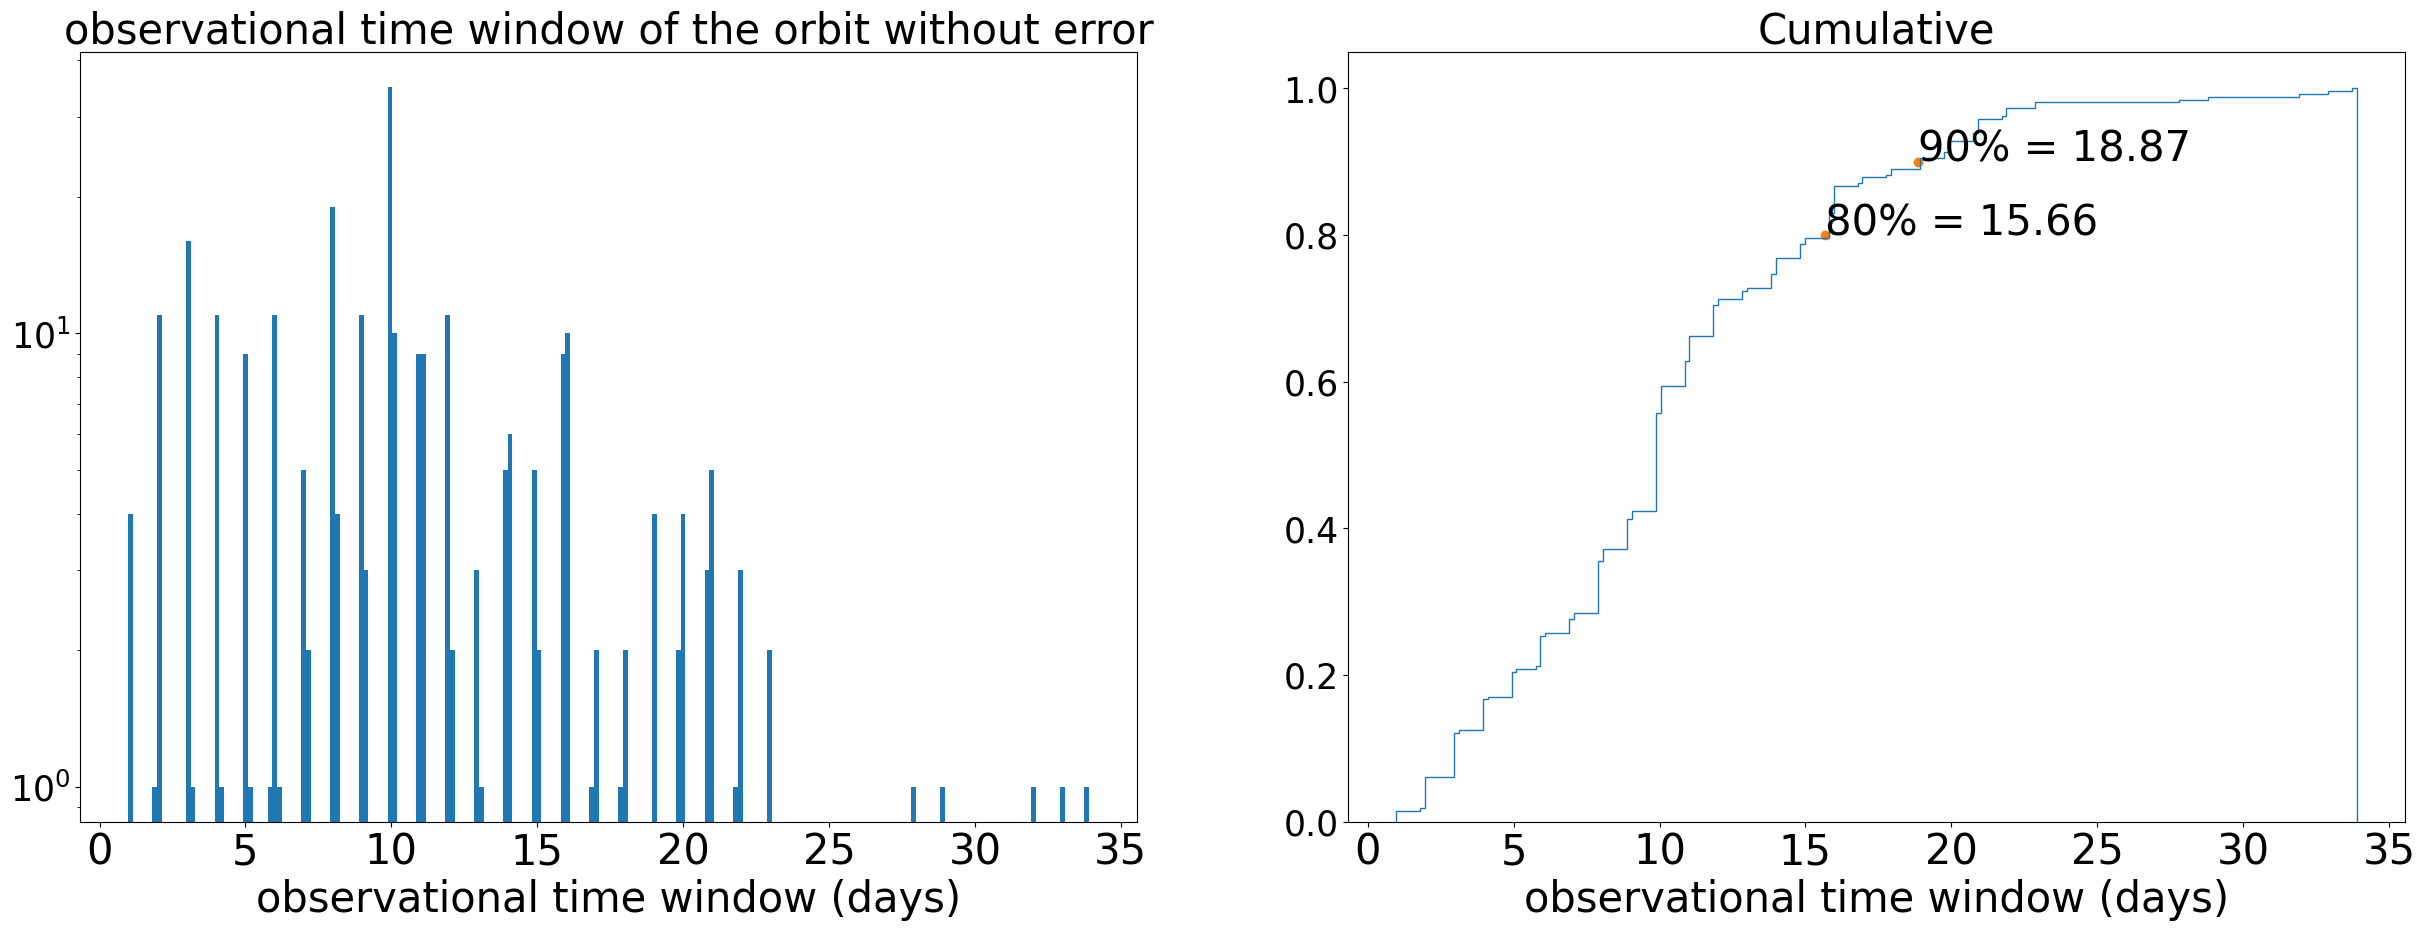

In [9]:
obstw_and_orb = candid_reconstr_orbit.merge(res_gb_obs_tw.reset_index(), on="d:ssoCandId")
u.plot_hist_and_cdf(
    obstw_and_orb[obstw_and_orb["d:rms_a"] == -1.0]["obs_win"], 
    None, "observational time window of the orbit without error", "observational time window (days)", "", 
    None, "Cumulative", "observational time window (days)", "")

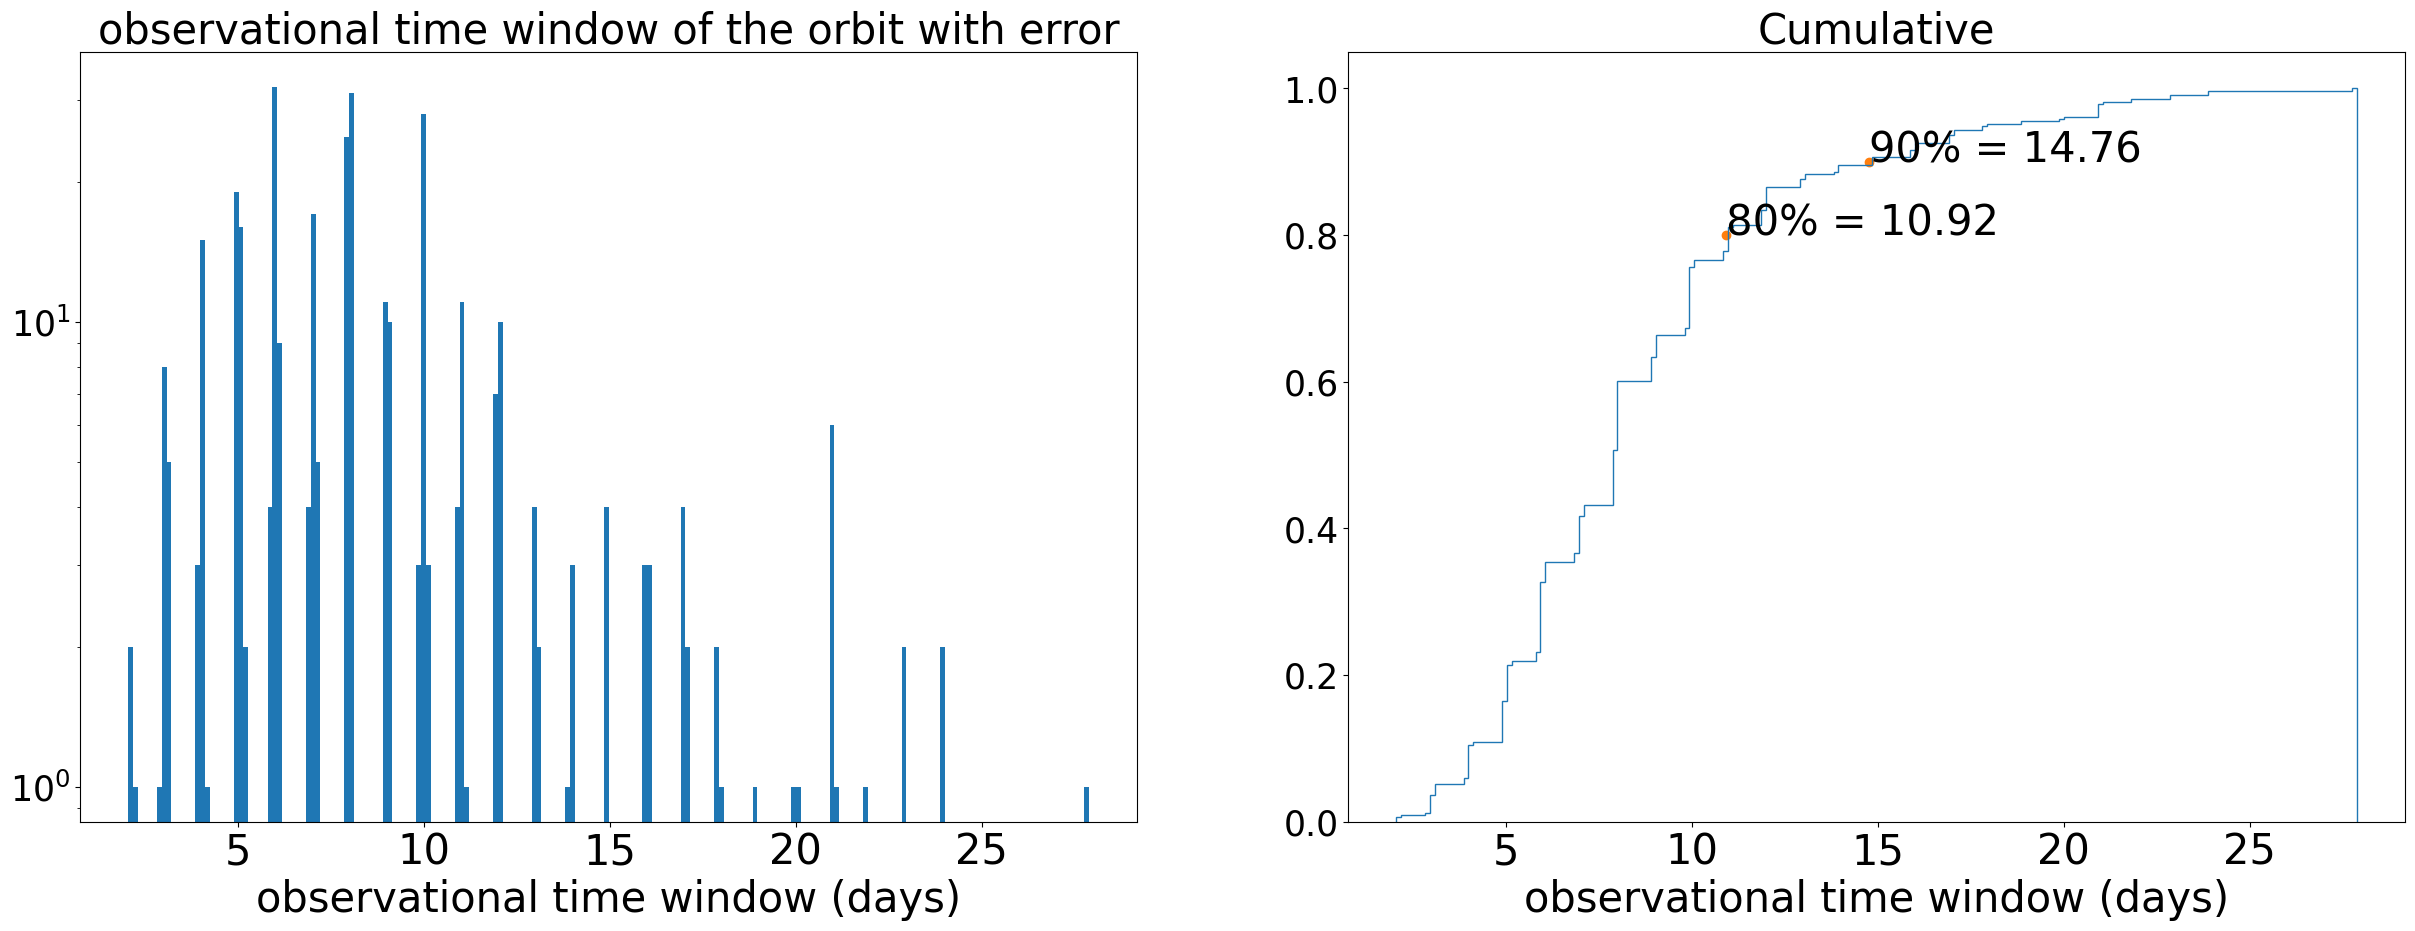

In [10]:
u.plot_hist_and_cdf(
    obstw_and_orb[obstw_and_orb["d:rms_a"] != -1.0]["obs_win"], 
    None, "observational time window of the orbit with error", "observational time window (days)", "", 
    None, "Cumulative", "observational time window (days)", "")

### Magnitude

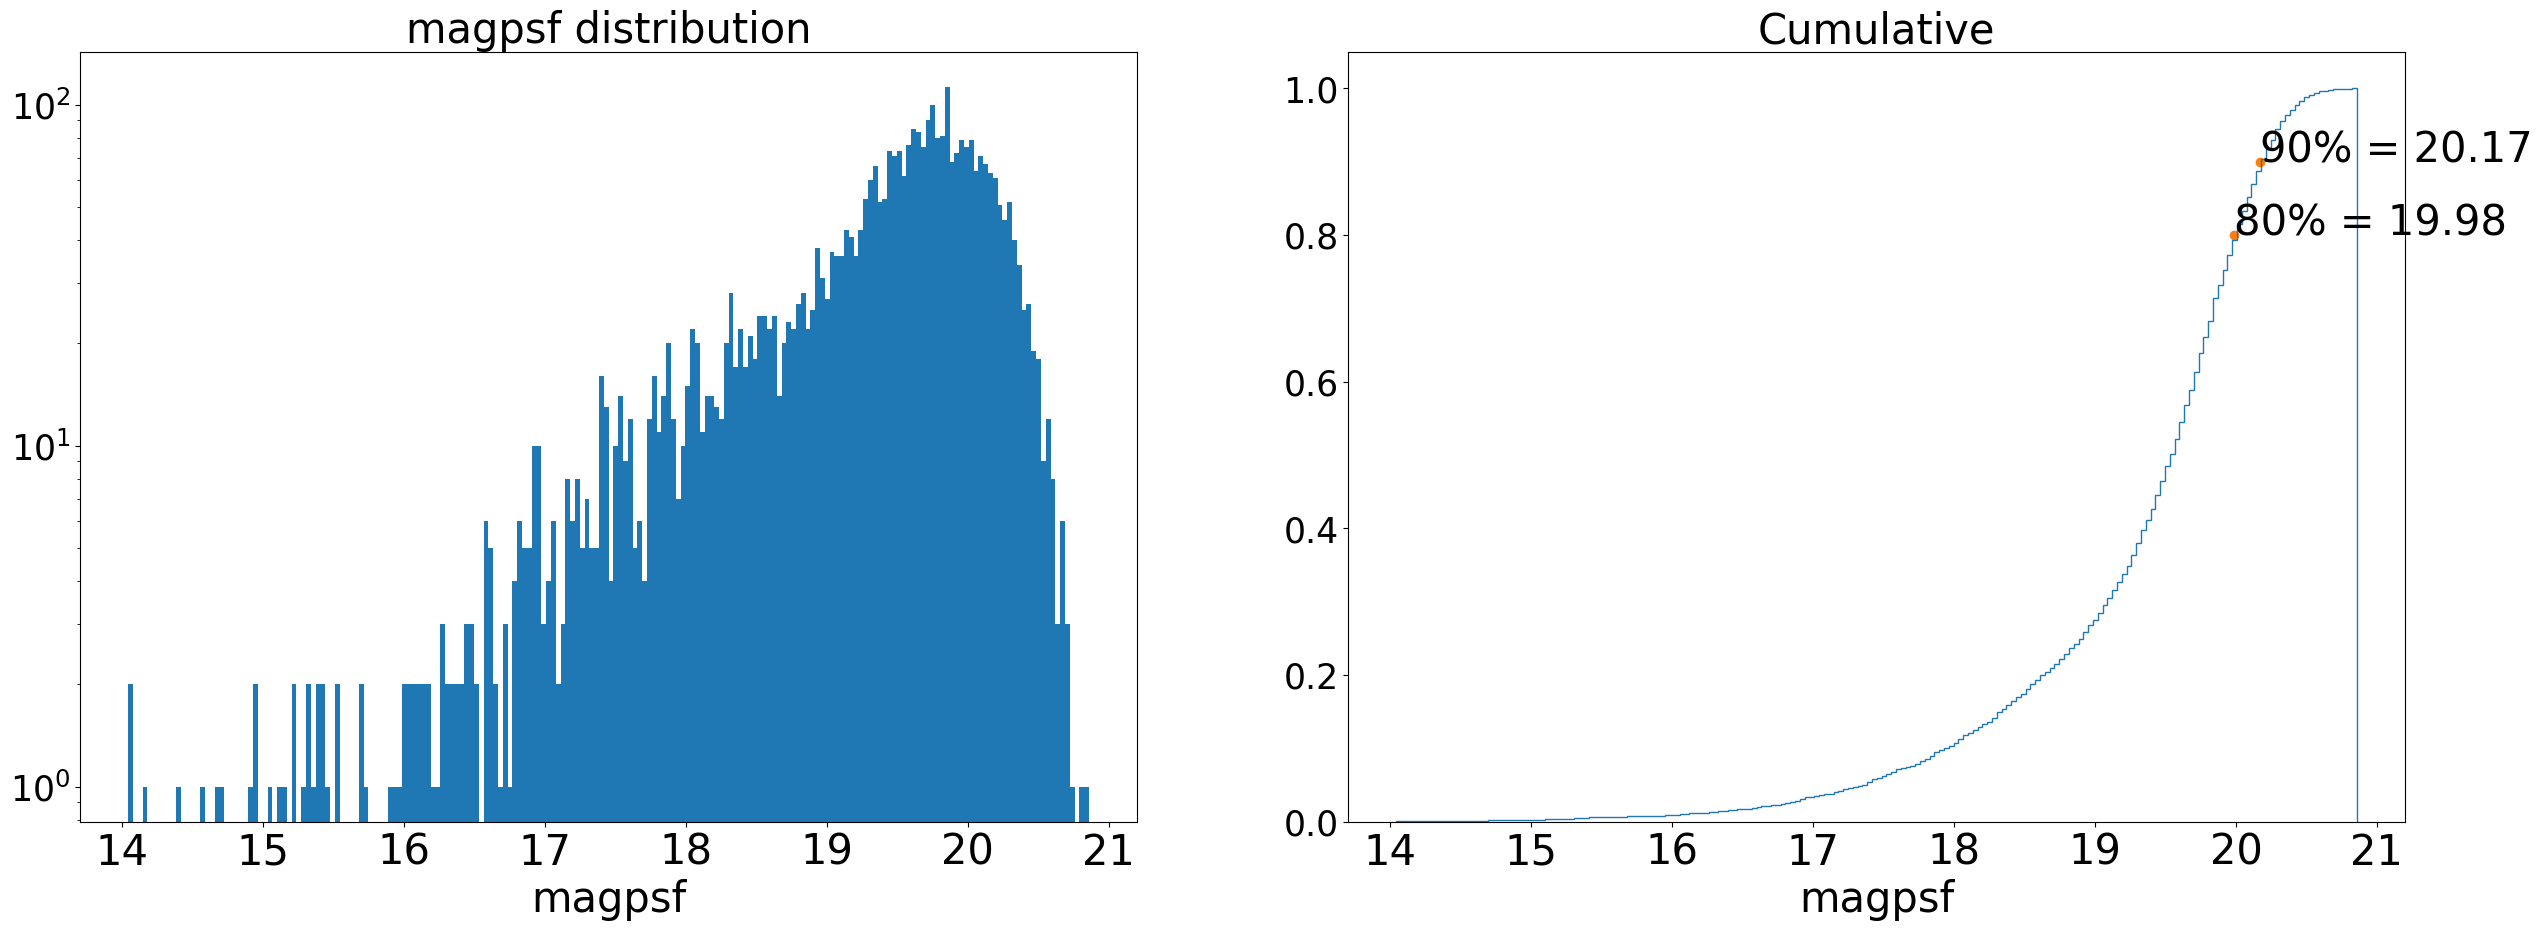

In [11]:
u.plot_hist_and_cdf(candid_reconstr_traje["d:magpsf"], None, "magpsf distribution", "magpsf", "", None, "Cumulative", "magpsf", "")

### RMS compared to confirmed reconstruction

In [12]:
from collections import Counter
path_tw_exp = "../fink_fat_experiments/time_window_experiments/15_2_2/all_assoc/confirmed_all_fink_fat/mpc"
reconstructed_orbit = pd.read_parquet(os.path.join(path_tw_exp, "orbital.parquet"))
reconstructed_trajectory = pd.read_parquet(os.path.join(path_tw_exp, "trajectory_orb.parquet"))

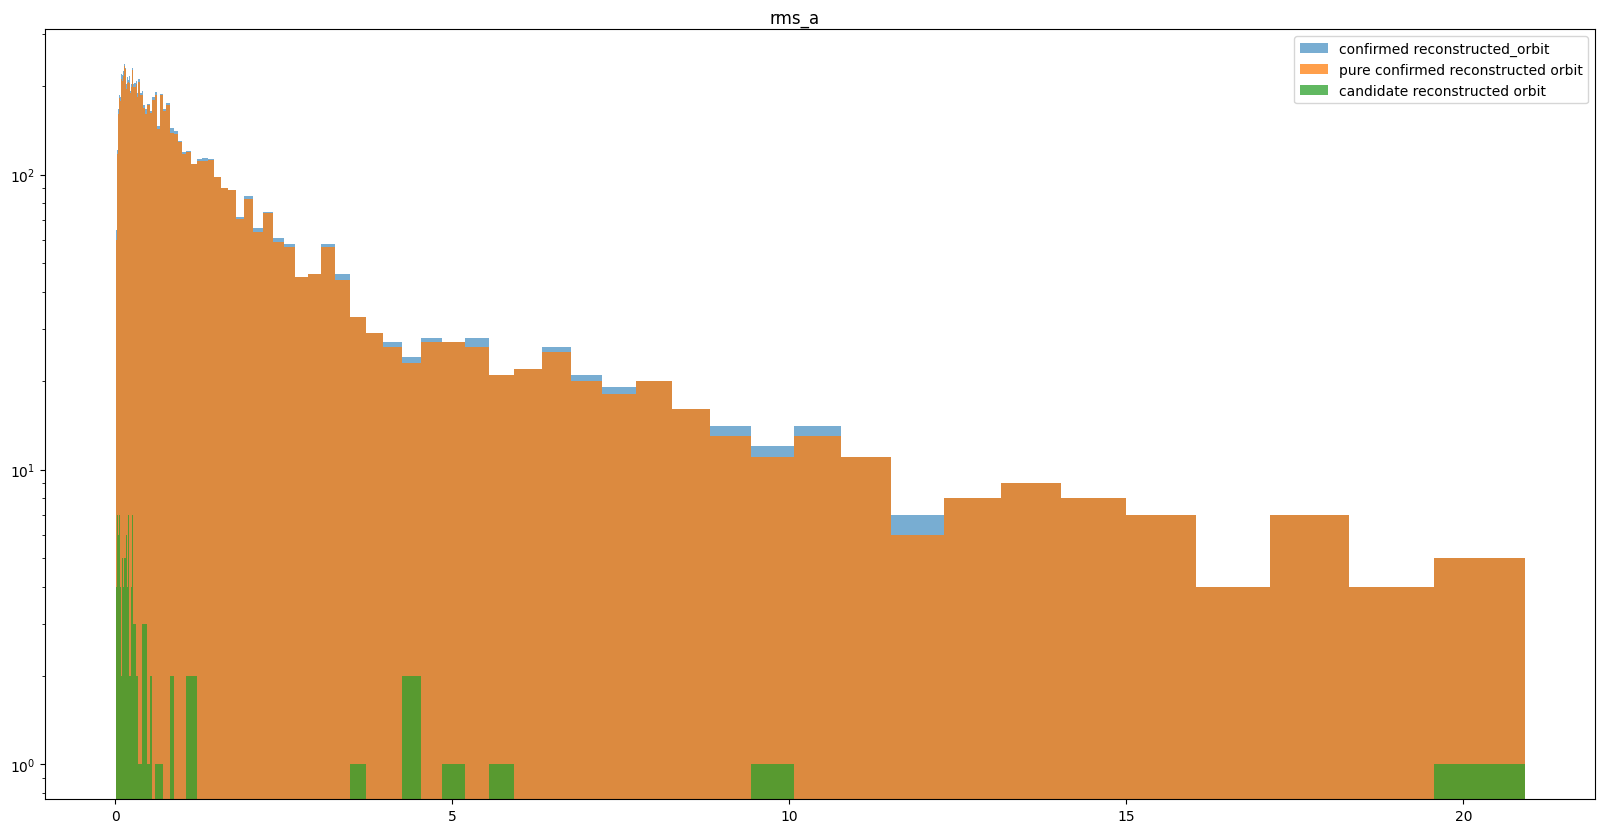

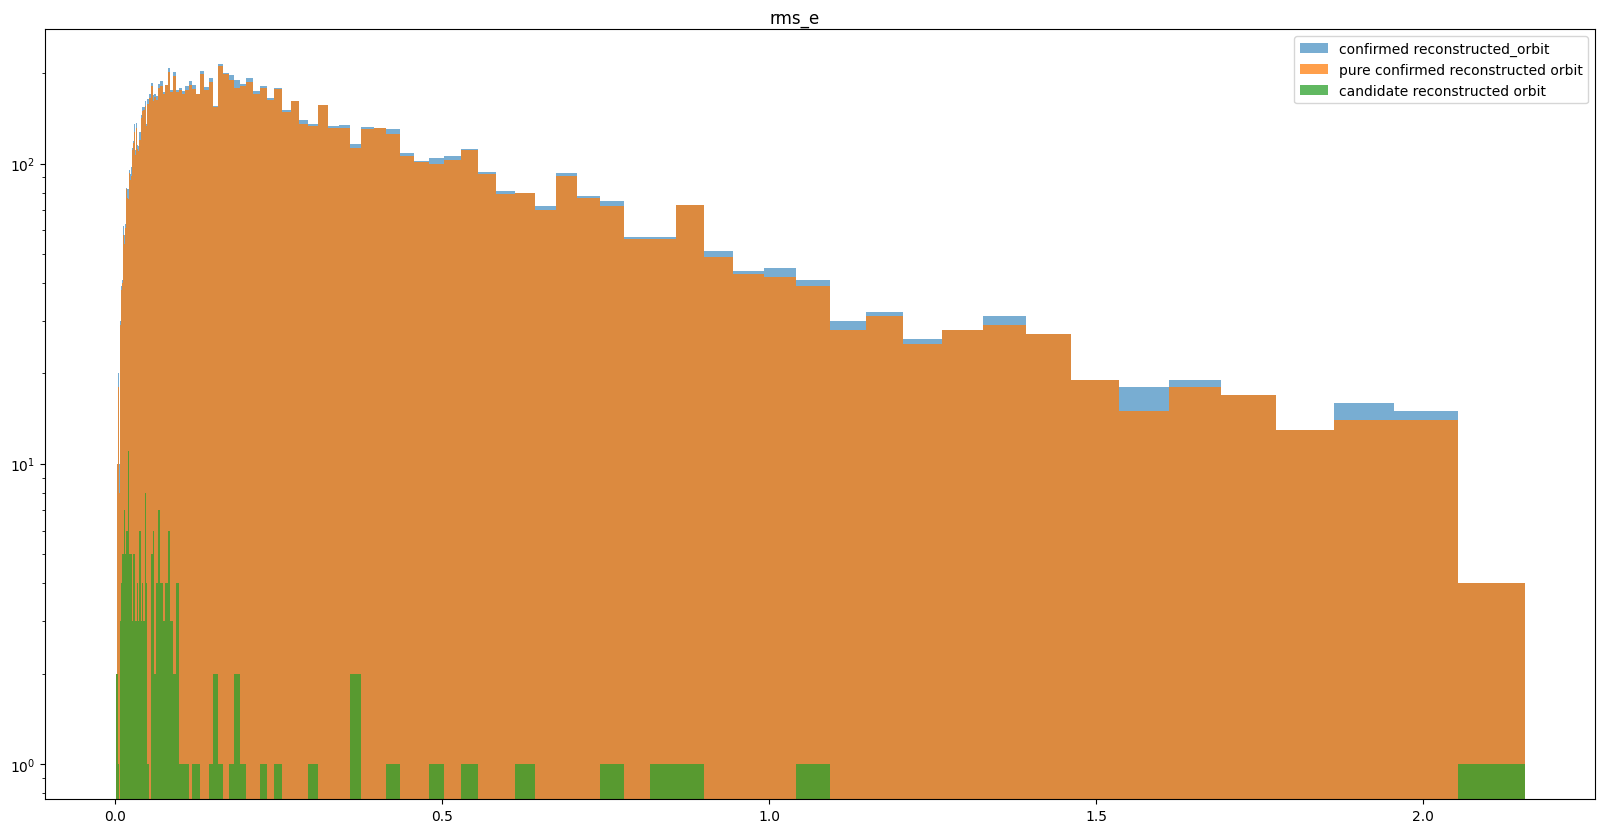

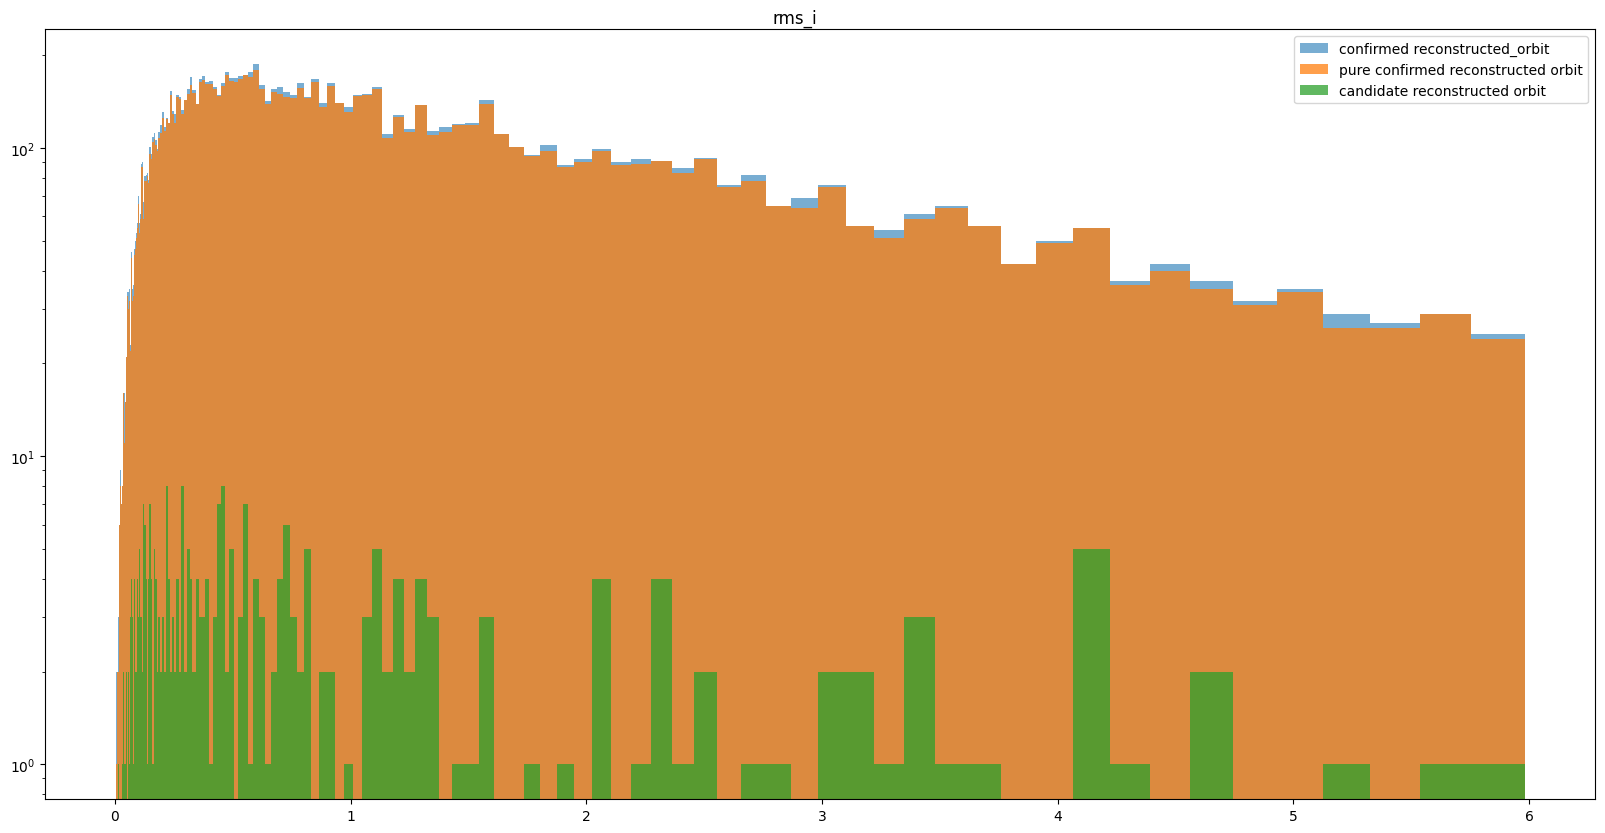

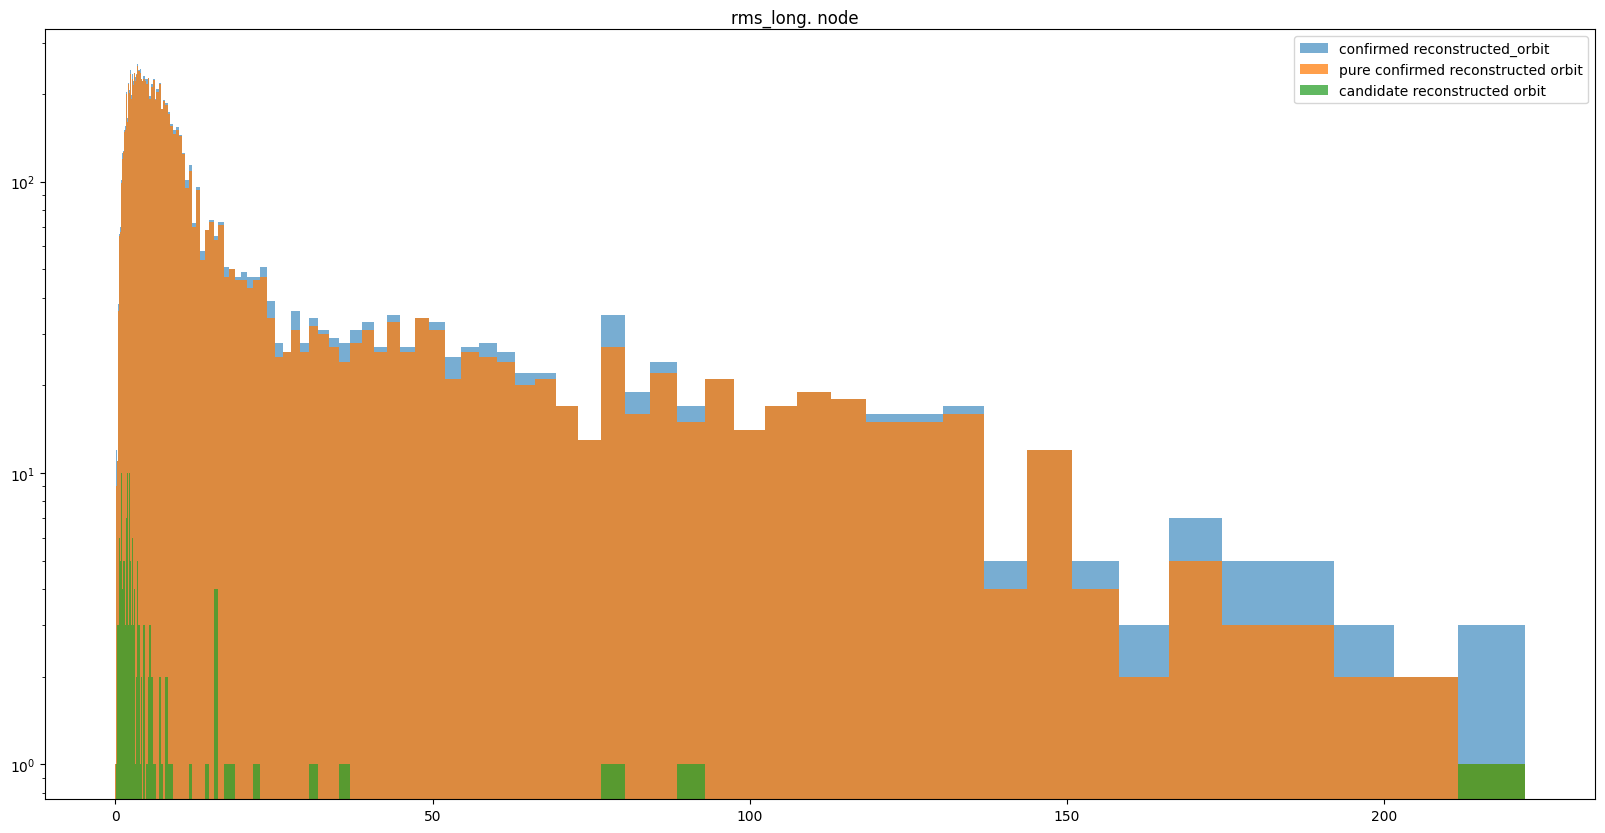

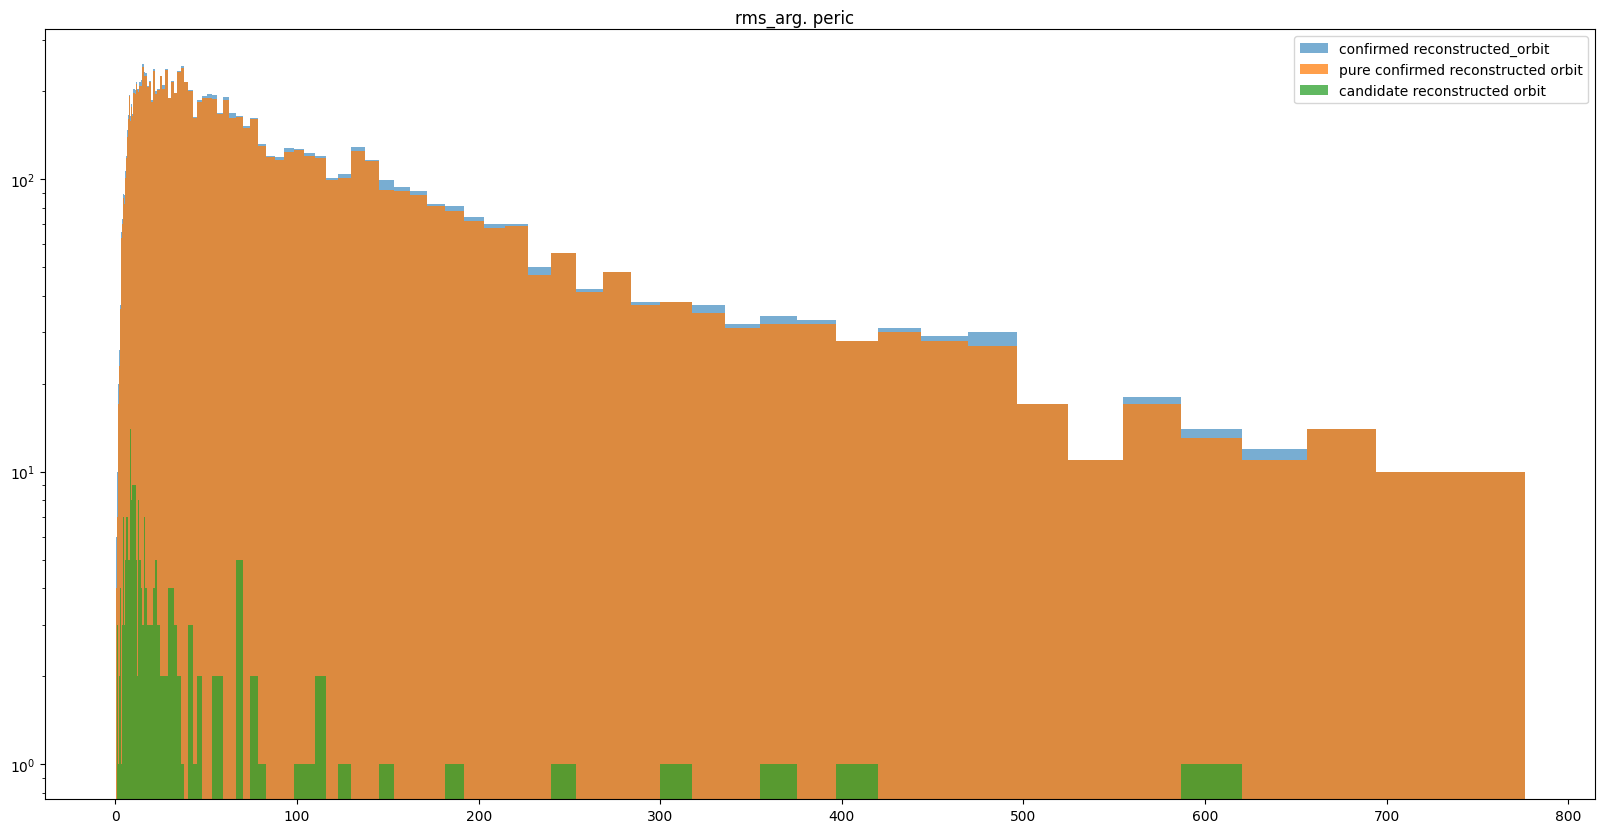

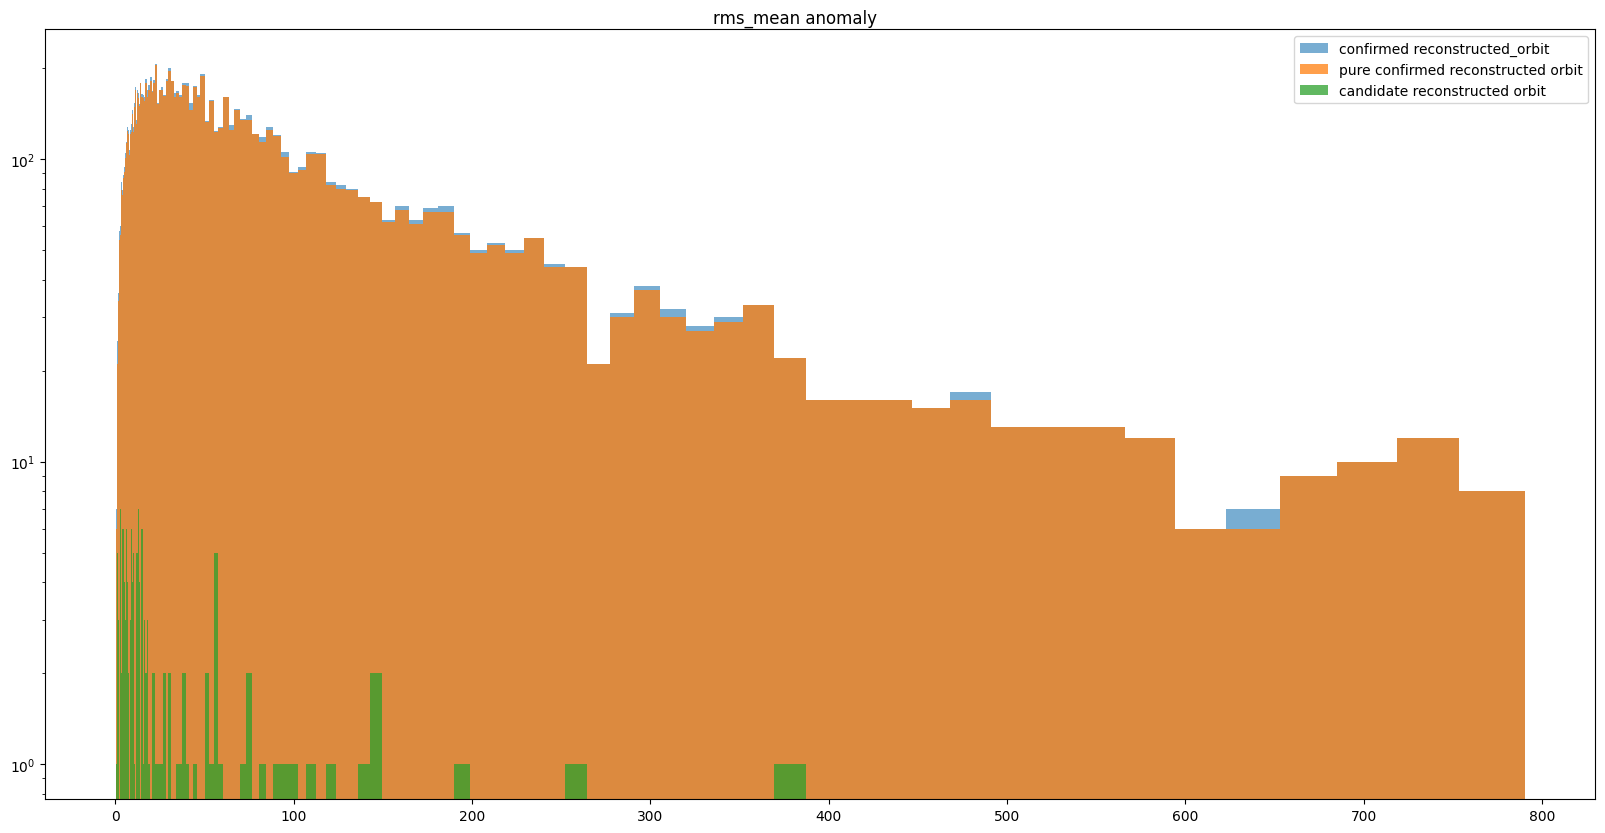

In [13]:
u.compare_confirmed_and_candidates_rms(
    reconstructed_orbit, 
    reconstructed_trajectory, 
    candid_reconstr_orbit[candid_reconstr_orbit["d:rms_a"] != -1.0]
)

#### SkyBot association

In [14]:
skybot_res = pd.read_parquet("skybot_result.parquet")

In [15]:
print("Alert with skybot counterpart: {:} ({:.2f} %)".format(len(skybot_res[skybot_res["Ast_Name"] != "null"]), (len(skybot_res[skybot_res["Ast_Name"] != "null"]) / len(skybot_res))*100))

Alert with skybot counterpart: 2509 (68.07 %)


In [16]:
(len(skybot_res[skybot_res["Ast_Name"] != "null"]) / len(skybot_res))*100

68.06836679327184

In [17]:
match_skybot = skybot_res[skybot_res["Ast_Name"] != "null"]

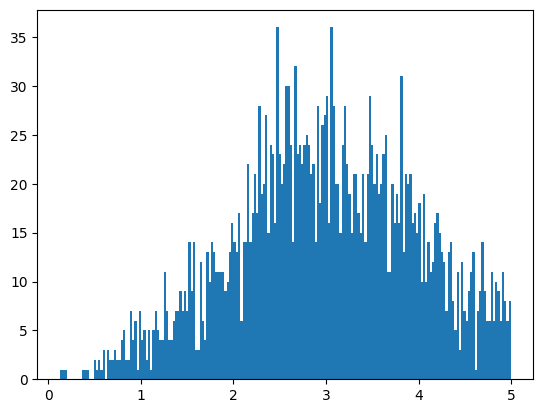

In [18]:
import matplotlib.pyplot as plt

plt.hist(match_skybot["centerdist"], bins=200)
plt.show()

In [19]:
purity_unknown = skybot_res.groupby("d:ssoCandId").agg(
    is_pure=("Ast_Name", lambda x: len(Counter(list(x)))),
    is_unknown=("Ast_Name", lambda x: len(Counter(x)) == 1 and list(Counter(x).keys())[0] == "null")
).reset_index()

In [20]:
pure_obj = purity_unknown[(purity_unknown["is_pure"] == 1) & ~(purity_unknown["is_unknown"])]

pure_traj = skybot_res[skybot_res["d:ssoCandId"].isin(pure_obj["d:ssoCandId"])]

In [21]:
print("Pure Candidate Trajectory: {:,} ({:.2f} %)".format(len(pure_obj), (len(pure_obj) / len(skybot_res.drop_duplicates("d:ssoCandId"))*100)))

Pure Candidate Trajectory: 208 (34.84 %)


In [22]:
not_pure_obj = purity_unknown[purity_unknown["is_pure"] != 1]
print("Not pure Candidate Trajectory: {:,} ({:.2f} %)".format(len(not_pure_obj), (len(not_pure_obj) / len(skybot_res.drop_duplicates("d:ssoCandId"))*100)))

Not pure Candidate Trajectory: 253 (42.38 %)


In [23]:
unknown_obj = purity_unknown[(purity_unknown["is_pure"] == 1) & (purity_unknown["is_unknown"])]
print("Unknown Candidate Trajectory: {:,} ({:.2f} %)".format(len(unknown_obj), (len(unknown_obj) / len(skybot_res.drop_duplicates("d:ssoCandId"))*100)))

Unknown Candidate Trajectory: 136 (22.78 %)


In [24]:
pure_obj

,d:ssoCandId,is_pure,is_unknown
0,FF2023aaaaaaa,1,False
1,FF2023aaaaaab,1,False
4,FF2023aaaaaae,1,False
7,FF2023aaaaaah,1,False
10,FF2023aaaaaak,1,False
...,...,...,...
521,FF2023aaaaaub,1,False
529,FF2023aaaaauj,1,False
535,FF2023aaaaaup,1,False
536,FF2023aaaaauq,1,False


### Candidate distribution

In [25]:
candid_reconstr_orbit["has_error"] = [True if x != -1.0 else False for x in  candid_reconstr_orbit["d:rms_a"]]

In [26]:
import seaborn as sns

In [27]:
mpc_ast_data = pd.read_parquet(
    "../data/MPC_Database/mpcorb_extended.parquet",
    columns=["Number", "Name", "Principal_desig", "Other_desigs", "a", "e", "i", "Node", "Peri", "M", "Epoch", "Orbit_type"]
)

confirmed_sso = u.load_data(["ssnamenr"])

In [28]:
mpc_in_fink, fink_not_in_mpc = u.mpc_crossmatch(mpc_ast_data, pd.Series(confirmed_sso["ssnamenr"].unique()))

In [29]:
#mpc_in_fink = mpc_in_fink.reset_index(drop=True).iloc[:1000]

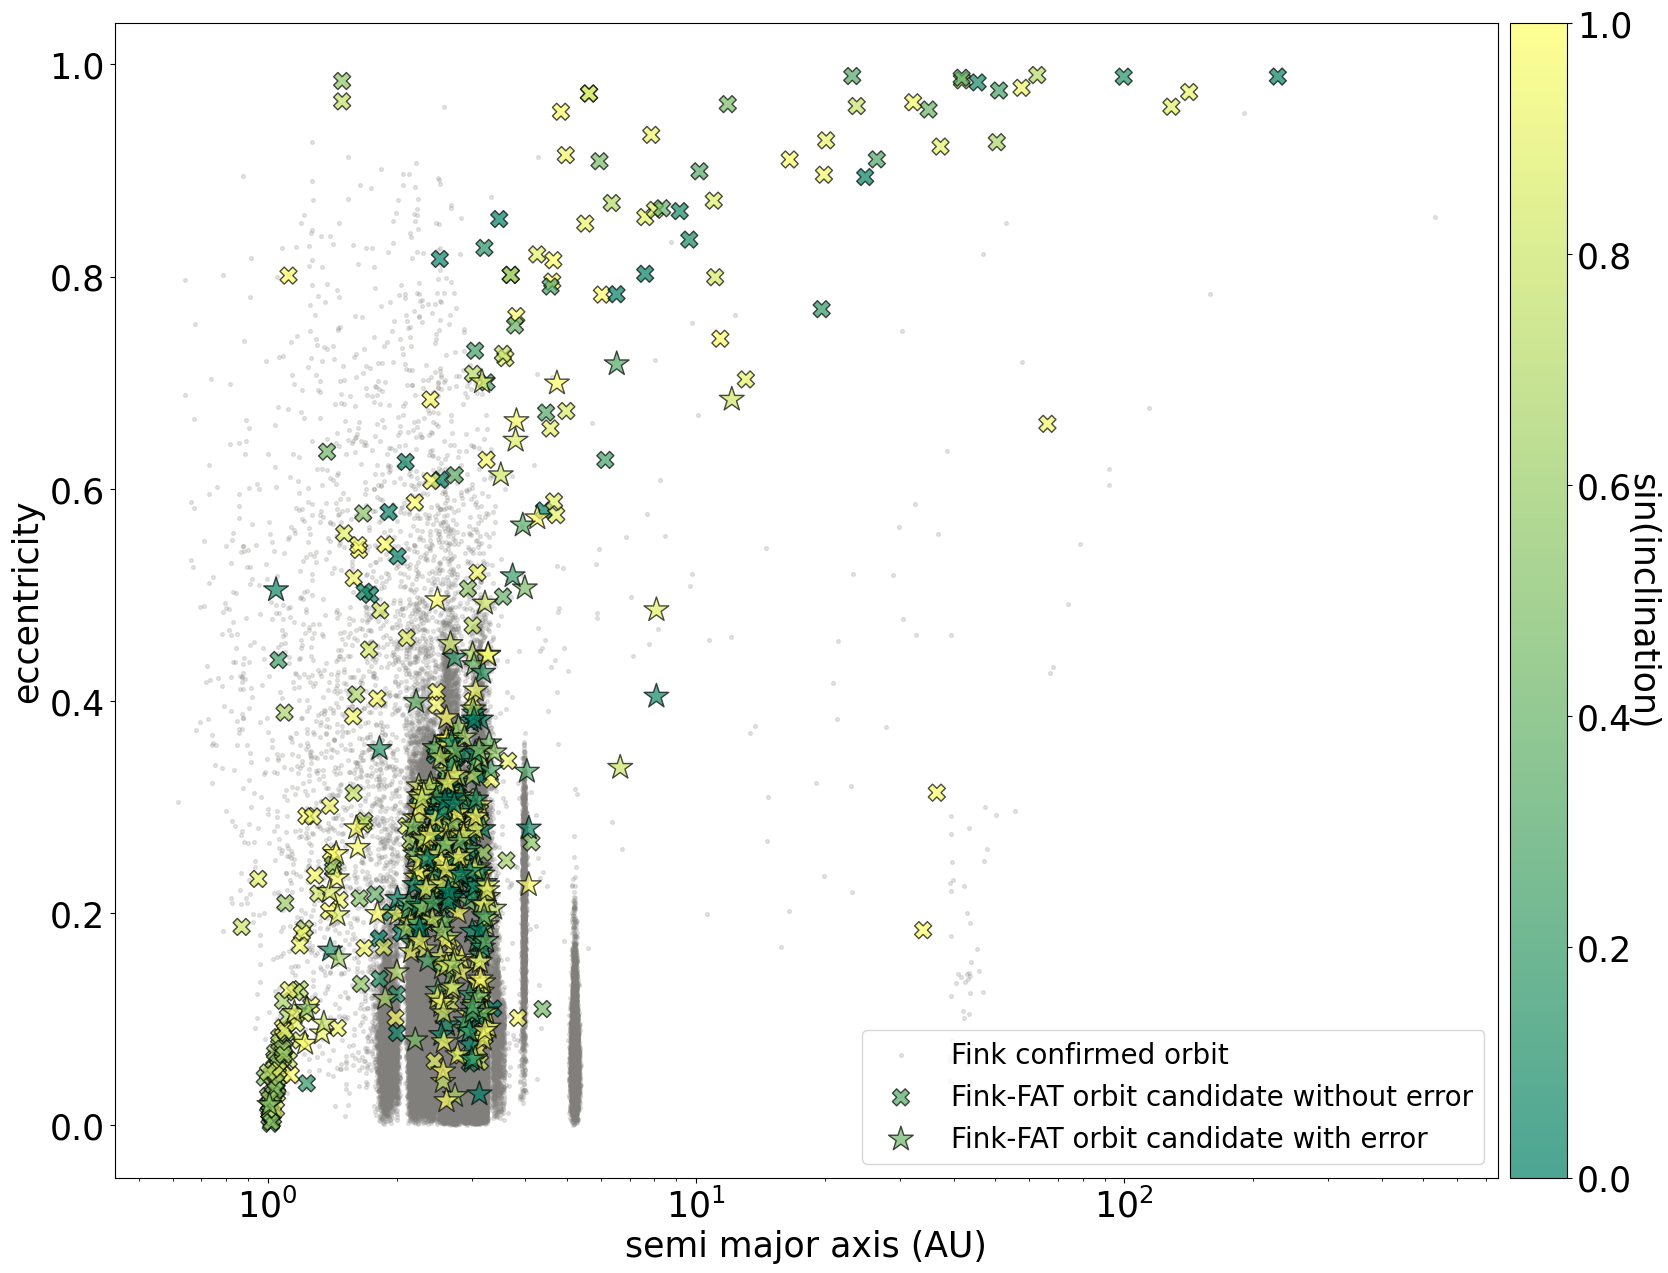

In [40]:
candid_reconstr_orbit["d:sin_i"] = np.sin(candid_reconstr_orbit["d:i"])


incl = candid_reconstr_orbit["d:sin_i"]
min_, max_ = incl.min(), incl.max()
candid_reconstr_orbit["d:norm(sin_i)"] = (candid_reconstr_orbit["d:sin_i"] - min_) / (max_ - min_)

incl = candid_reconstr_orbit["d:norm(sin_i)"]
min_, max_ = incl.min(), incl.max()

fig = plt.figure(figsize=(30, 15))

cm = plt.cm.get_cmap('summer')

ax = plt.gca()
ax.set_xscale("log")

#sns.kdeplot(data=main_belt, x="a", y="e", thresh=0.5, alpha=0.6, cbar=False, ax=ax, label="MBA")
#sns.kdeplot(data=aten, x="a", y="e", thresh=0.5, alpha=0.6, cbar=False, ax=ax, label="Aten")

plt.scatter(
    mpc_in_fink["a"], 
    mpc_in_fink["e"], 
    c="#807f7c", 
    s=30,
    marker=".",
    alpha=0.2, 
    label="Fink confirmed orbit"
)

with_error = candid_reconstr_orbit[candid_reconstr_orbit["has_error"]]
without_error = candid_reconstr_orbit[~candid_reconstr_orbit["has_error"]]

sc = plt.scatter(
    without_error["d:a"], 
    without_error["d:e"], 
    c=without_error["d:norm(sin_i)"],
    edgecolors='black',
    s=150,
    cmap=cm,
    marker="X",
    label="Fink-FAT orbit candidate without error",
    alpha=0.7
)
plt.clim(min_, max_)


sc = plt.scatter(
    with_error["d:a"], 
    with_error["d:e"], 
    c=with_error["d:norm(sin_i)"],
    edgecolors='black',
    marker="*",
    s=350,
    cmap=cm, 
    label="Fink-FAT orbit candidate with error",
    alpha=0.7
)
plt.clim(min_, max_)


cbar = sc.figure.colorbar(sc, fraction=0.4, pad=0.005)

cbar.set_label("sin(inclination)", rotation=270, fontsize=25, labelpad=19)
cbar.ax.tick_params(labelsize=25)

ax.tick_params(axis="x", which="major", labelsize=25)
ax.tick_params(axis="y", which="major", labelsize=25)
ax.set_xlabel("semi major axis (AU)", fontsize=25)
ax.set_ylabel("eccentricity", fontsize=25)

ax.legend(prop={"size": 20})
plt.show()